# Bragg grating sections

Bragg gratings are often used in waveguides, such as optical fibres, which can reflect light of certain frequencies while transmitting others. This is typically achieved by periodically changing the refractive index or dielectric constant in a section of the waveguide, and the reflective and transmitting frequency bands are controlled by appropriately designing the periodicity and material or geometry parameters of the grating.

In this example, sections of two Bragg gratings will be simulated. The first one involves a waveguide with a perfectly aligned corrugation on either side, which causes it to act as a reflector. The second one is similar, but with the corrugation on one side misaligned with the corrugation on the other side, so that the structure primarily transmits power.

Reference:  Xu Wang, Yun Wang, Jonas Flueckiger, Richard Bojko, Amy Liu, Adam Reid, James Pond, Nicolas A. F. Jaeger, and Lukas Chrostowski, "Precise control of the coupling coefficient through destructive interference in silicon waveguide Bragg gratings," _Opt. Lett._ 39, 5519-5522 (2014), DOI: [10.1364/OL.39.005519](https://doi.org/10.1364/OL.39.005519)

In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# Tidy3D imports
import tidy3d as td


## Structure Setup

First, the geometry of the structure is defined. Both waveguides are set up in the same simulation side-by-side.

In [2]:
# materials
Air = td.Medium(permittivity=1.0)
Si = td.Medium(permittivity=3.47**2)
SiO2 = td.Medium(permittivity=1.44**2)

# geometric parameters
wg_height = 0.22
wg_feed_length = 0.75
wg_feed_width = 0.5
corrug_width = 0.05
num_periods = 50
period = 0.324

shift = period / 2
corrug_length = period / 2
wg_length = num_periods * period
wg_width = wg_feed_width - corrug_width

wavelength0 = 1.532
freq0 = td.C_0 / wavelength0
fwidth = freq0 / 40.0
run_time = 4.0e-12
wavelength_min = td.C_0 / (freq0 + fwidth)

# place the two waveguides with their centres half a free-space wavelength apart
wg1_y = wavelength0 / 2
wg2_y = -wavelength0 / 2

# small buffer added to structures so they extend into the PML a bit
pml_buffer = period

# waveguide 1
wg1_size = [wg_length + pml_buffer, wg_width, wg_height]
wg1_center = [0, wg1_y, wg_height / 2]
wg1_medium = Si

# waveguide 2
wg2_size = [wg_length + pml_buffer, wg_width, wg_height]
wg2_center = [0, wg2_y, wg_height / 2]
wg2_medium = Si

# corrugation setup for waveguide 1
cg1_size = [corrug_length, corrug_width, wg_height]
cg1_center_plus = [
    -wg_length / 2 + corrug_length / 2,
    wg_width / 2 + corrug_width / 2 + wg1_y,
    wg_height / 2,
]
cg1_center_minus = [
    -wg_length / 2 + corrug_length / 2,
    -wg_width / 2 - corrug_width / 2 + wg1_y,
    wg_height / 2,
]
cg1_medium = Si

# corrugation setup for waveguide 2
cg2_size = [corrug_length, corrug_width, wg_height]
cg2_center_plus = [
    -wg_length / 2 + corrug_length / 2,
    wg_width / 2 + corrug_width / 2 + wg2_y,
    wg_height / 2,
]
cg2_center_minus = [
    -wg_length / 2 + corrug_length / 2 + shift,
    -wg_width / 2 - corrug_width / 2 + wg2_y,
    wg_height / 2,
]
cg2_medium = Si

# substrate
sub_size = [td.inf, td.inf, 2]
sub_center = [0, 0, -1.0]
sub_medium = SiO2

# create the substrate
substrate = td.Structure(
    geometry=td.Box(center=sub_center, size=sub_size),
    medium=sub_medium,
    name="substrate",
)

# create the first waveguide
waveguide_1 = td.Structure(
    geometry=td.Box(center=wg1_center, size=wg1_size),
    medium=wg1_medium,
    name="waveguide_1",
)

# create the second waveguide
waveguide_2 = td.Structure(
    geometry=td.Box(center=wg2_center, size=wg2_size),
    medium=wg2_medium,
    name="waveguide_2",
)

# create the corrugation for the first waveguide
corrug1_plus = []
corrug1_minus = []
for i in range(num_periods):
    # corrugation on the +y side
    center = cg1_center_plus
    if i > 0:
        center[0] += period
    plus = td.Structure(
        geometry=td.Box(center=center, size=cg1_size),
        medium=cg1_medium,
        name=f"corrug1_plus_{i}",
    )

    # corrugation on the -y side
    center = cg1_center_minus
    if i > 0:
        center[0] += period
    minus = td.Structure(
        geometry=td.Box(center=center, size=cg1_size),
        medium=cg1_medium,
        name=f"corrug1_minus_{i}",
    )

    corrug1_plus.append(plus)
    corrug1_minus.append(minus)

# create the corrugation for the second waveguide
corrug2_plus = []
corrug2_minus = []
for i in range(num_periods):
    # corrugation on the +y side
    center = cg2_center_plus
    if i > 0:
        center[0] += period
    plus = td.Structure(
        geometry=td.Box(center=center, size=cg2_size),
        medium=cg2_medium,
        name=f"corrug2_plus_{i}",
    )

    # corrugation on the -y side
    center = cg2_center_minus
    if i > 0:
        center[0] += period
    minus = td.Structure(
        geometry=td.Box(center=center, size=cg2_size),
        medium=cg2_medium,
        name=f"corrug2_minus_{i}",
    )

    corrug2_plus.append(plus)
    corrug2_minus.append(minus)

# full simulation domain
sim_size = [
    wg_length + wavelength0 * 1.5,
    2 * wavelength0 + wg_width + 2 * corrug_width,
    3.7,
]
sim_center = [0, 0, 0.0]

# boundary conditions - Bloch boundaries are used to emulate an infinitely long grating
boundary_spec = td.BoundarySpec(
    # x=td.Boundary.bloch(bloch_vec=num_periods/2),
    x=td.Boundary.pml(),
    y=td.Boundary.pml(),
    z=td.Boundary.pml(),
)

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20)


## Source Setup

A mode source is defined for each waveguide.

In [3]:
# mode source for waveguide 1
source1_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth, amplitude=1)
mode_src1 = td.ModeSource(
    center=[-wg_length / 2 + period, wg1_y, wg_height / 2],
    size=[0, waveguide_1.geometry.size[1] * 2, waveguide_1.geometry.size[2] * 2],
    mode_index=0,
    direction="+",
    source_time=source1_time,
    mode_spec=td.ModeSpec(),
)

# mode source for waveguide 2
source2_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth, amplitude=1)
mode_src2 = td.ModeSource(
    center=[-wg_length / 2 + period, wg2_y, wg_height / 2],
    size=[0, waveguide_2.geometry.size[1] * 2, waveguide_2.geometry.size[2] * 2],
    mode_index=0,
    direction="+",
    source_time=source2_time,
    mode_spec=td.ModeSpec(),
)


## Monitor Setup

To visualize the field distribution in the waveguides, a monitor is placed in the `xy` plane cutting through both waveguides. A pair of flux monitors is also placed on the far side the demonstrate the transmission and reflection characteristics.

In [4]:
# create monitors
monitor_xy = td.FieldMonitor(
    center=[0, 0, wg_height / 2],
    size=[wg_length, 2 * wavelength0 + wg_width + 2 * corrug_width, 0],
    freqs=[freq0],
    name="fields_xy",
)

freqs = np.linspace(freq0 - 2 * fwidth, freq0 + 2 * fwidth, 200)
monitor_flux_aligned = td.FluxMonitor(
    center=[wg_length / 2 - period, wg1_y, wg_height / 2],
    size=[0, waveguide_1.geometry.size[1] * 2, waveguide_1.geometry.size[2] * 2],
    freqs=freqs,
    name="flux_aligned",
)

monitor_flux_misaligned = td.FluxMonitor(
    center=[wg_length / 2 - period, wg2_y, wg_height / 2],
    size=[0, waveguide_2.geometry.size[1] * 2, waveguide_2.geometry.size[2] * 2],
    freqs=freqs,
    name="flux_misaligned",
)


## Create Simulation

All the structures, sources, and monitors are consolidated, and the simulation is created and visualized.

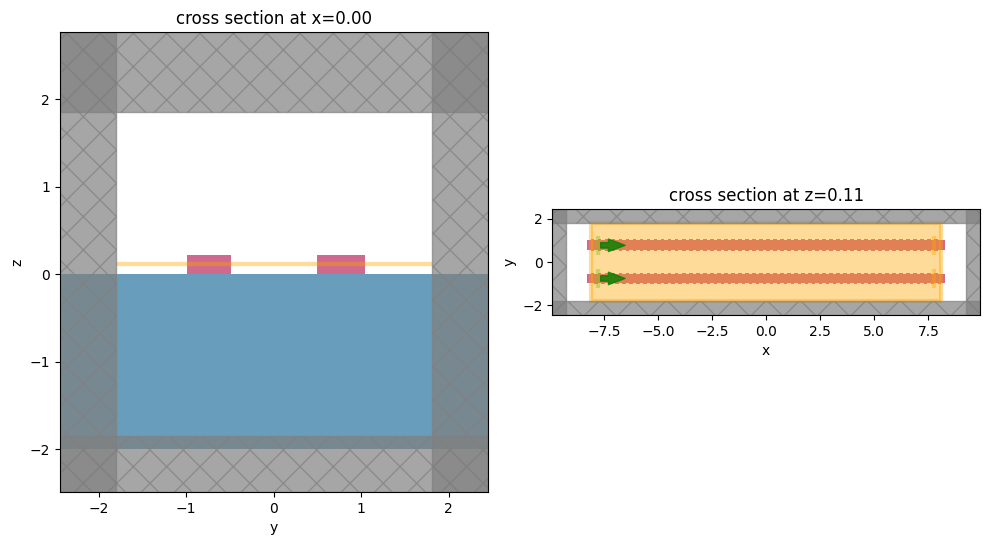

In [5]:
# list of all structures
structures = (
    [substrate, waveguide_1, waveguide_2]
    + corrug1_plus
    + corrug1_minus
    + corrug2_plus
    + corrug2_minus
)

# list of all sources
sources = [mode_src1, mode_src2]

# list of all monitors
monitors = [monitor_xy, monitor_flux_aligned, monitor_flux_misaligned]

# create the simulation
sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=grid_spec,
    structures=structures,
    sources=sources,
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
)

# plot the simulation domain
f, (ax1, ax3) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 6))
sim.plot(x=0, ax=ax1)
sim.plot(z=wg_height / 2, ax=ax3)
plt.show()


## Run Simulation

In [6]:
# run simulation
import tidy3d.web as web

sim_data = web.run(sim, task_name="bragg", path="data/bragg.hdf5", verbose=True)


[17:53:51] Created task 'bragg' with task_id 'fdve-23fa4da2-dd23-4dca-92cb-3a9aba80fb3ev1'.           ]8;id=115611;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=759353;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=222988;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=722781;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=268673;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23fa4da2-dd23-4dca-92cb-3a9aba80fb3ev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=39503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23fa4da2-dd23-4dca-92cb-3a9aba80fb3ev1\taskId]8;;\]8;id=268673;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23fa4da2-dd23-4dca-92cb-3a9aba80fb3ev1\=]8;;\]8;id=172530;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23fa4da2-dd23-4dca-92cb-3a9aba80fb3ev1\fdve]8;;\]8;id=268673;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23fa4da2-dd23-4dca-92cb-3a9aba80fb3ev1\-23fa4da2-dd23-4dca-92cb-3a9aba80fb3]8;;\              
           ]8;id=268673;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23fa4da2-dd23-4dca-92cb-3a9aba80fb3ev1\ev1']8;;\.                                                                                                   

Output()

[17:53:53] status = queued                                                                            ]8;id=918129;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=797076;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#321\321]8;;\

Output()

[17:54:02] status = preprocess                                                                        ]8;id=546975;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=758233;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#315\315]8;;\

[17:54:10] Maximum FlexCredit cost: 0.368. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=522908;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=937794;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=331657;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=539407;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=583510;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=996728;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#352\352]8;;\

Output()

[17:56:59] early shutoff detected, exiting.                                                           ]8;id=950509;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=54708;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=270391;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=373973;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#383\383]8;;\

Output()

[17:57:06] status = success                                                                           ]8;id=273610;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=37944;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#390\390]8;;\

Output()

[17:57:08] loading SimulationData from data/bragg.hdf5                                                ]8;id=849543;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=902714;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#568\568]8;;\

## Field Plot

The frequency-domain fields are plotted in the `xy` plane cutting through the waveguides. We notice that the grating with aligned corrugation effectively reflects power at the design frequency, while the misalignment in the second grating causes it to be mostly transmissive.

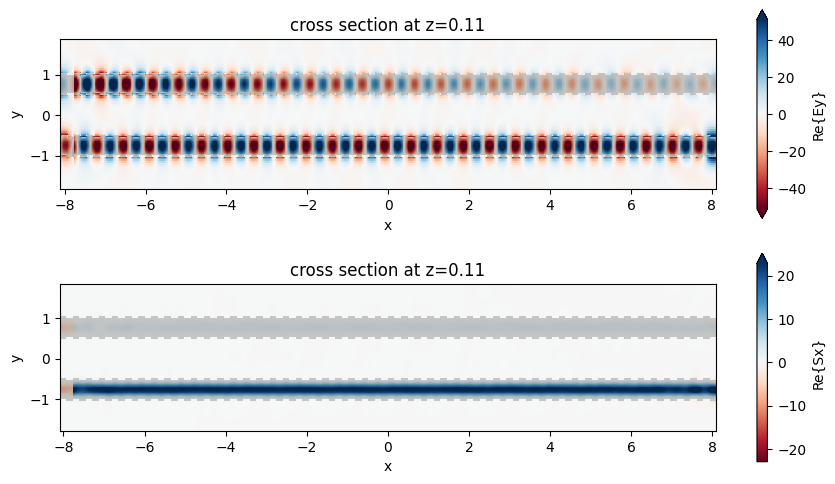

In [7]:
# plot fields on the monitor
fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(9, 5))
sim_data.plot_field(
    field_monitor_name="fields_xy", field_name="Ey", val="real", f=freq0, ax=ax[0]
)
sim_data.plot_field(
    field_monitor_name="fields_xy", field_name="Sx", val="real", f=freq0, ax=ax[1]
)
plt.show()


## Transmission and Reflection

The observations made in the field plot above can be confirmed by plotting the flux recorded by the flux monitors as a function of frequency. In the region of the design frequency, indicated by the dashed black line, the drop in flux for the aligned-corrugation grating confirms its reflective property. 

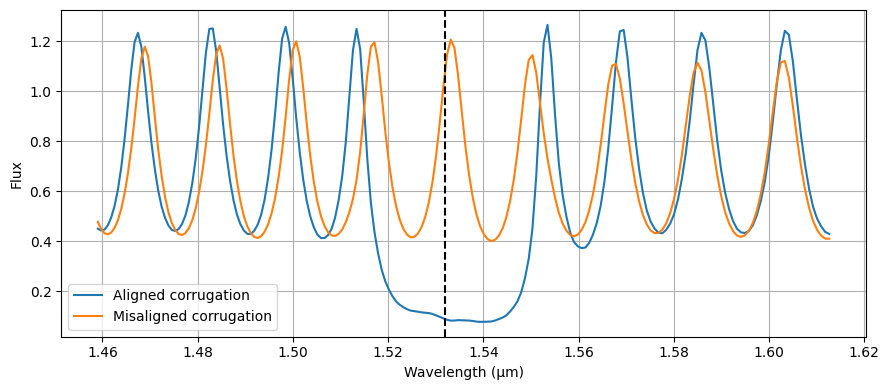

In [8]:
fig, ax = plt.subplots(figsize=(9, 4), tight_layout=True)

# plot transmitted flux for each waveguide
ax.plot(td.C_0 / freqs, sim_data["flux_aligned"].flux, label="Aligned corrugation")
ax.plot(
    td.C_0 / freqs, sim_data["flux_misaligned"].flux, label="Misaligned corrugation"
)

# vertical line at design frequency
ax.axvline(td.C_0 / freq0, ls="--", color="k")

ax.set(xlabel="Wavelength (µm)", ylabel="Flux")
ax.grid(True)
plt.legend()
plt.show()
